### Mini Project Codebase

In [66]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# List of Zambian-related Wikipedia pages
pages = [
    "History_of_Zambia",
    "Economy_of_Zambia",
    "University_Teaching_Hospital",
    "Lusaka",
    "University_of_Zambia"
]

In [70]:
# Function to fetch and parse Wikipedia page
def get_page_content(page_title):
    url = f"https://en.wikipedia.org/wiki/{page_title}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'}
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return BeautifulSoup(response.text, 'html.parser')
    except requests.RequestException as e:
        print(f"Error fetching {page_title}: {e}")
        return None

In [72]:
# Function to extract section features
def extract_section_features(section, section_level):
    text = section.get_text().strip()
    word_count = len(re.findall(r'\w+', text))
    references = len(section.find_all('sup', class_='reference'))
    image_count = len(section.find_all('img'))
    return {
        'Word_Count': word_count,
        'References': references,
        'Images': image_count,
        'Section_Depth': section_level
    }


In [74]:
# Function to assign ground-truth labels
def assign_completeness_label(word_count, references):
    if word_count > 100 and references >= 1:
        return "Complete"
    elif word_count > 50 or references == 1:
        return "Partial"
    else:
        return "Incomplete"

In [76]:
# Initialize data storage
data = []

# Collect and preprocess data
for page in pages:
    soup = get_page_content(page)
    if not soup:
        print(f"Skipping {page} due to fetch error")
        continue
    
# Find all heading divs (mw-heading for h2 and h3)
    heading_divs = soup.find_all('div', class_=re.compile('mw-heading mw-heading[2-3]'))
    
    for i, heading_div in enumerate(heading_divs):
        # Extract title from h2 or h3 tag's id attribute
        section = heading_div.find(['h2', 'h3'])
        if not section:
            print("Skipping section with no h2/h3 tag")
            continue
        title = section.get('id') or section.get_text().strip()
        if not title or title in ['mw-hidden-catlinks', 'mw-references']:
            print(f"Skipping section with invalid title: {title}")
            continue
        section_title = re.sub(r'\[edit\]', '', title).strip()
        
        # Determine section depth (h2=1, h3=2)
        section_level = 1 if section.name == 'h2' else 2
        
        # Collect content until the next heading div or end of page
        content = []
        current = heading_div.next_sibling
        while current and not (current.name == 'div' and 'mw-heading' in current.get('class', [])):
            if current.name and current.name not in ['script', 'style']:  # Exclude scripts/styles
                content.append(current)
            current = current.next_sibling if current else None
        
        if not content:
            print(f"Section {section_title} has no content, skipping")
            continue
        
        section_soup = BeautifulSoup(''.join(str(c) for c in content), 'html.parser')
        
        # Extract features
        features = extract_section_features(section_soup, section_level)
        
        # Assign ground-truth label
        completeness = assign_completeness_label(features['Word_Count'], features['References'])
        
        # Store data
        data.append({
            'Page': page,
            'Section': section_title,
            'Word_Count': features['Word_Count'],
            'References': features['References'],
            'Images': features['Images'],
            'Section_Depth': features['Section_Depth'],
            'Completeness': completeness
        })

Section Multi-party_democracy has no content, skipping
Section History has no content, skipping
Section Sectors has no content, skipping


In [51]:
# Create DataFrame
df = pd.DataFrame(data)

# Verify data
if df.empty:
    print("\nError: No data collected. Check network connection or Wikipedia page structure.")
else:
    print(f"\nCollected {len(df)} sections")
    print(df.head())

# Save raw data
df.to_csv('raw_data.csv', index=False)
print("\nRaw data saved to 'raw_data.csv'")


Collected 93 sections
                Page                 Section  Word_Count  References  Images  \
0  History_of_Zambia         Prehistoric_era          65           1       0   
1  History_of_Zambia       Khoisan_and_Batwa         153           2       1   
2  History_of_Zambia          Bantu_(Abantu)         138           1       1   
3  History_of_Zambia           Bantu_origins          96           1       0   
4  History_of_Zambia  First_Bantu_settlement         585           4       5   

   Section_Depth Completeness  
0              1      Partial  
1              1     Complete  
2              1     Complete  
3              2      Partial  
4              2     Complete  

Raw data saved to 'raw_data.csv'


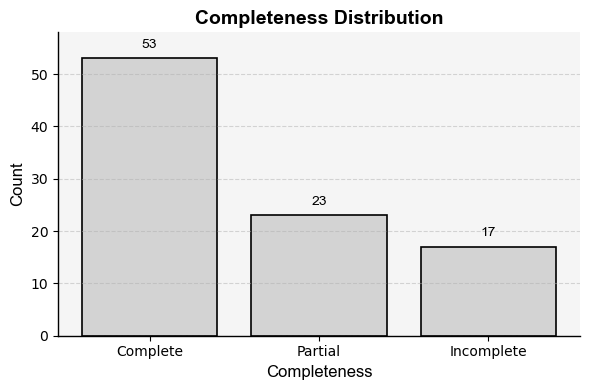


Completeness distribution plot saved to 'completeness_distribution.png'


In [34]:
# Generate completeness distribution plot
completeness_counts = df['Completeness'].value_counts().reindex(['Complete', 'Partial', 'Incomplete'], fill_value=0)
plt.figure(figsize=(6, 4), facecolor='white')
ax = plt.gca()
ax.set_facecolor('#f5f5f5')
bars = plt.bar(completeness_counts.index, completeness_counts.values, color='lightgrey', edgecolor='black', linewidth=1.2)
plt.xlabel('Completeness', fontsize=12, fontfamily='Arial')
plt.ylabel('Count', fontsize=12, fontfamily='Arial')
plt.title('Completeness Distribution', fontsize=14, fontfamily='Arial', fontweight='bold')
for i, v in enumerate(completeness_counts.values):
    plt.text(i, v + 1.5, str(v), ha='center', va='bottom', fontsize=10, fontfamily='Arial')
plt.ylim(0, max(completeness_counts.values) + 5)
ax.grid(True, axis='y', linestyle='--', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.savefig('completeness_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("\nCompleteness distribution plot saved to 'completeness_distribution.png'")

In [36]:
# Prepare data for classification
if not df.empty:
    X = df[['Word_Count', 'References', 'Images', 'Section_Depth']]
    y = df['Completeness']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Predict on test set
    y_pred = clf.predict(X_test)

    # Evaluate model
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Predict completeness for all data
    df['Predicted_Completeness'] = clf.predict(X)

    # Display results
    print("\nProcessed Data:")
    print(df[['Page', 'Section', 'Word_Count', 'References', 'Completeness', 'Predicted_Completeness']])

    # Export processed data
    df.to_csv('zambian_wikipedia_completeness.csv', index=False)
    print("\nProcessed data exported to 'zambian_wikipedia_completeness.csv'")

    # Save preprocessed features
    X.to_csv('preprocessed_features.csv', index=False)
    print("Preprocessed features saved to 'preprocessed_features.csv'")
else:
    print("\nSkipping classification due to empty dataset")


Classification Report:
              precision    recall  f1-score   support

    Complete       1.00      1.00      1.00        11
  Incomplete       1.00      0.67      0.80         3
     Partial       0.83      1.00      0.91         5

    accuracy                           0.95        19
   macro avg       0.94      0.89      0.90        19
weighted avg       0.96      0.95      0.94        19


Processed Data:
                    Page                 Section  Word_Count  References  \
0      History_of_Zambia         Prehistoric_era          65           1   
1      History_of_Zambia       Khoisan_and_Batwa         153           2   
2      History_of_Zambia          Bantu_(Abantu)         138           1   
3      History_of_Zambia           Bantu_origins          96           1   
4      History_of_Zambia  First_Bantu_settlement         585           4   
..                   ...                     ...         ...         ...   
88  University_of_Zambia            Affiliatio